In [1]:
cd ..

/home/xyz


In [2]:
import sys
import time
from itertools import accumulate

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from tqdm import tqdm

from incdbscan import IncrementalDBSCAN
from incdbscan.tests.testutils import are_lists_isomorphic, read_text_data_file_from_url

# Read data

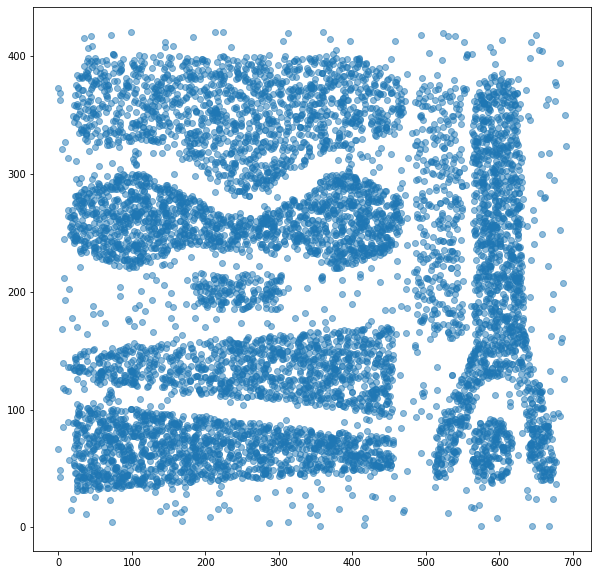

In [3]:
# This is equivalent to the t8.8k data set from the Chameleon collection by Karypis, G. et al.
# Also available from: http://glaros.dtc.umn.edu/gkhome/cluto/cluto/download

url = "https://raw.githubusercontent.com/yeahia2508/ml-examples/master/Data/clustering/chameleon/t8.8k.txt"
data = read_text_data_file_from_url(url)

plt.figure(figsize=(10, 10))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5)

The data set can be meaningfully clustered with DBSCAN with settings `eps`=10, `min_samples`=10.

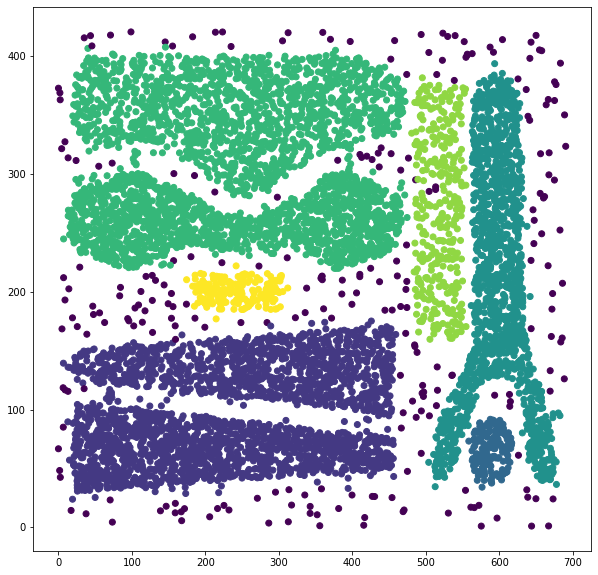

In [4]:
dbscan = DBSCAN(eps=10, min_samples=5)
labels_dbscan = dbscan.fit_predict(data)

plt.figure(figsize=(10, 10))
plt.scatter(data[:, 0], data[:, 1], alpha=1, c=labels_dbscan)

In [5]:
incdbscan = IncrementalDBSCAN(eps=10, min_pts=5)
labels_incdbscan = incdbscan.insert(data).get_cluster_labels(data)

In [6]:
# are the results really the same
assert are_lists_isomorphic(labels_dbscan, labels_incdbscan)

# Performance

In [7]:
dbscan = DBSCAN(eps=10, min_samples=5)
incdbscan = IncrementalDBSCAN(eps=10, min_pts=5)

time_dbscan_insert = []
time_incdbscan_insert = []
time_incdbscan_delete = []

# Measure insertion

for i in tqdm(range(len(data))):
    t0 = time.time()
    incdbscan.insert(data[[i]])
    t1 = time.time()
    time_incdbscan_insert.append(t1 - t0)
    
    t0 = time.time()
    dbscan.fit(data[:i+1])
    t1 = time.time()
    time_dbscan_insert.append(t1 - t0)

# Measure deletion
    
for i in tqdm(range(len(data))):
    t0 = time.time()
    incdbscan.delete(data[[i]])
    t1 = time.time()
    time_incdbscan_delete.append(t1 - t0)


100%|███████████████████████████████████████████████████████████████████| 8000/8000 [02:30<00:00, 53.08it/s]


In [8]:
def smooth(numbers, window=50):
    return pd.Series(numbers).rolling(window, center=True).mean()

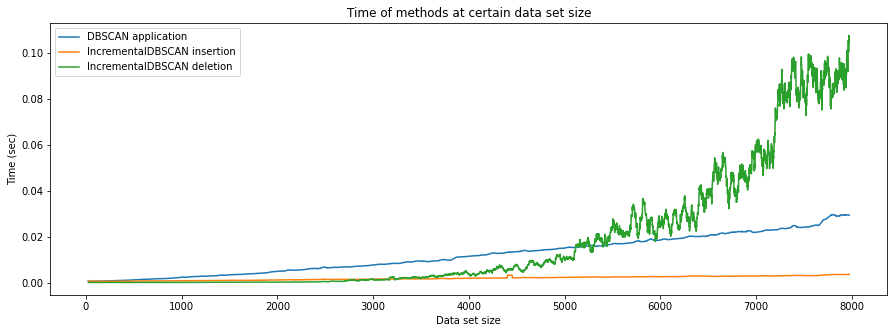

In [9]:
plt.figure(figsize=(15, 5))

plt.plot(smooth(time_dbscan_insert), label='DBSCAN application')
plt.plot(smooth(time_incdbscan_insert), label='IncrementalDBSCAN insertion')
plt.plot(smooth(reversed(time_incdbscan_delete)), label='IncrementalDBSCAN deletion')

plt.legend()
plt.title('Time of methods at certain data set size')
plt.xlabel('Data set size')
plt.ylabel('Time (sec)')
plt.show()

What can we see here?

1) The cost of **inserting** a new data point into IncrementalDBSCAN is quite small and **grows slower** than the cost of applying (`scikit-learns`'s) DBSCAN to a whole data set.  In other words, *given that* we have a data set _D_ clustered with IncrementalDBSCAN, and we want to see which cluster would a new object _P_ belong to, it is faster to insert _P_ into the current IncrementalDBSCAN clustering than to apply DBSCAN to the union of _D_ and _P_.
   
2) The cost of **deleting** a data point from IncrementalDBSCAN **grows faster** than the cost of applying (`scikit-learns`'s) DBSCAN to the data set minus that data point. Thus, the cost of deletion in IncrementalDBSCAN is quite small below a certain data set size, but becomes larger as data set size grows.

## Performance of applying DBSCAN vs applying IncrementalDBSCAN

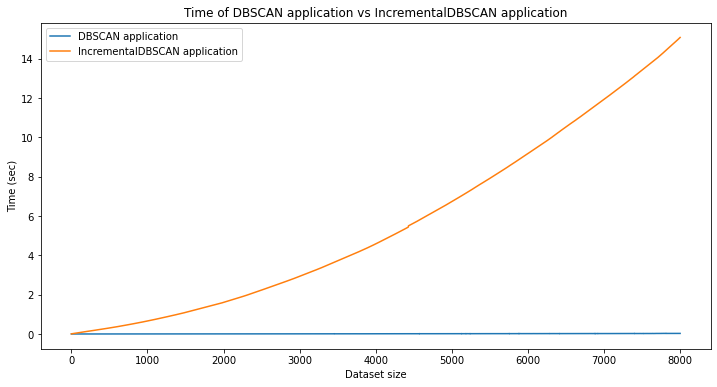

In [10]:
cumulated_time_incdbscan_insert = list(accumulate(time_incdbscan_insert))

plt.figure(figsize=(12, 6))

plt.plot(time_dbscan_insert, label='DBSCAN application')
plt.plot(cumulated_time_incdbscan_insert, label='IncrementalDBSCAN application')

plt.legend()
plt.title('Time of DBSCAN application vs IncrementalDBSCAN application')
plt.xlabel('Dataset size')
plt.ylabel('Time (sec)')
plt.show()

To show another perspective let's see this chart as well. It is visible that applying IncrementalDBSCAN **to the whole data set** is much more costly than applying DBSCAN as the size of data grows.  

### Additional note

Batch insertion time can be reduced with better implementation of the `insert` method of IncrementalDBSCAN.